## 対応の無い3標本以上の二元配置分散分析の事例

異なる母集団から無作為抽出された3つ以上の標本にてついて、因子の効果や交互作用の効果を検定する。

### (0)事前準備

In [27]:
# ライブラリ
import os
import sys
sys.path.append("../../scripts")
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
np.random.seed(111)
import random
random.seed(111)

# scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
# graph
import matplotlib.pyplot as plt
import seaborn as sns

# scripts
import utils as u
# graph setting
u.graph_setting()

### (0) テーマのためのデータセット

In [28]:
# seabornのライブラリに含まれるexerciseのデータセットを使う
df = sns.load_dataset("exercise")
print(df.head())

   Unnamed: 0  id     diet  pulse    time  kind
0           0   1  low fat     85   1 min  rest
1           1   1  low fat     85  15 min  rest
2           2   1  low fat     88  30 min  rest
3           3   2  low fat     90   1 min  rest
4           4   2  low fat     92  15 min  rest


### (0) データを確認

In [29]:
# パラメータの確認
df[["diet", "time", "kind"]].value_counts()

diet     time    kind   
no fat   1 min   rest       5
                 walking    5
low fat  30 min  walking    5
                 rest       5
         15 min  running    5
                 walking    5
                 rest       5
         1 min   running    5
                 walking    5
                 rest       5
no fat   30 min  running    5
                 walking    5
                 rest       5
         15 min  running    5
                 walking    5
                 rest       5
         1 min   running    5
low fat  30 min  running    5
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


no fat : 45
low fat : 45


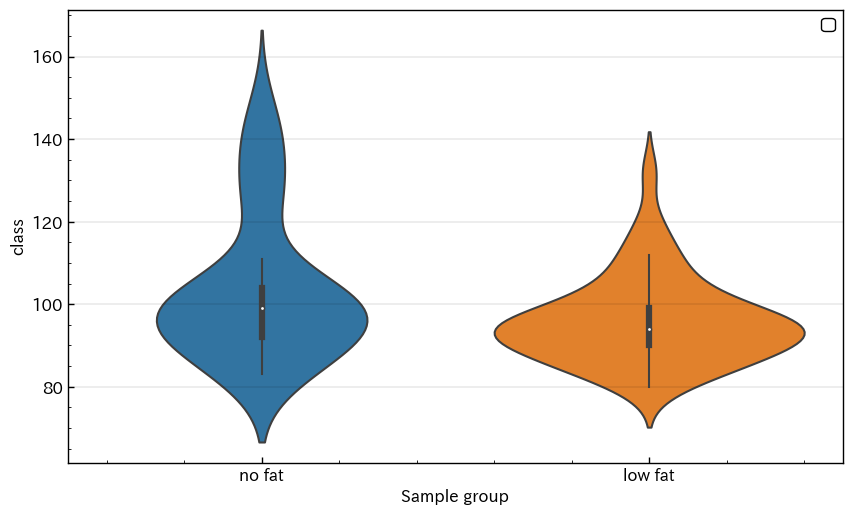

In [21]:
#　violin plot
fig, ax = plt.subplots(figsize=(10,6))

values1 = df[df["diet"]=="no fat"]["pulse"].values
values2 = df[df["diet"]=="low fat"]["pulse"].values

print(f"no fat : {len(values1)}")
print(f"low fat : {len(values2)}")

data = pd.concat([
       pd.DataFrame({"Sample":["no fat" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["low fat" for i in range(len(values2))],
                     "Values":values2}),
       ]).reset_index(drop=True)

sns.violinplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("class")
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


rest : 30
walking : 30
running : 30


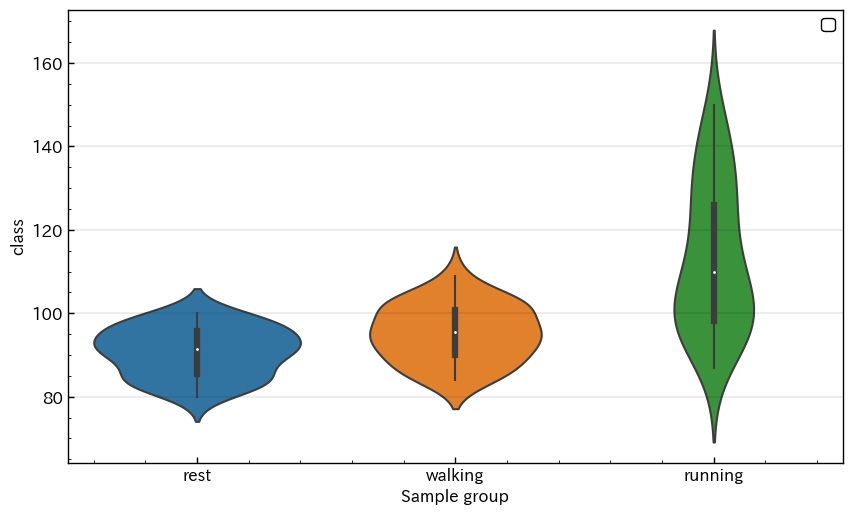

In [22]:
#　violin plot
fig, ax = plt.subplots(figsize=(10,6))

values1 = df[df["kind"]=="rest"]["pulse"].values
values2 = df[df["kind"]=="walking"]["pulse"].values
values3 = df[df["kind"]=="running"]["pulse"].values

print(f"rest : {len(values1)}")
print(f"walking : {len(values2)}")
print(f"running : {len(values3)}")

data = pd.concat([
       pd.DataFrame({"Sample":["rest" for i in range(len(values1))],
                     "Values":values1}),
       pd.DataFrame({"Sample":["walking" for i in range(len(values2))],
                     "Values":values2}),
       pd.DataFrame({"Sample":["running" for i in range(len(values2))],
                     "Values":values3}),
       ]).reset_index(drop=True)

sns.violinplot(data=data, x="Sample", y="Values")
ax.set_xlabel("Sample group")
ax.set_ylabel("class")
ax.legend()

### (0) 想定する分析シーン

- 体形と運動行動に対する心拍数の関係を調べる。<br>
- それぞれの体形や運動行動の平均値に差があるといえるか？を統計的に検定する。<br>

### (1) 問題設定
- 帰無仮説$H_0$と対立仮説$H_1$を定義する。<br>

帰無仮説$H_0$：各体系および運動行動での心拍数の平均値は変わらない。<br>
対立仮説$H_1$：心拍数の平均値が異なる。<br>

### (2) 適切な検定方法を選択する。
- 検定の目的、データの確認結果、サンプル数から適切な検定方法を選択する。<br>

1. 検定の目的<br>
-> 3つの異なる母集団から、それぞれ無作為抽出された3つの標本グループについて、その標本平均が等しいかどうか？を検定する。
-> 体形と運動行動(休憩、ウォーキング、ランニング)の2要因の組み合わせについて確認する。

2. データの確認 (ただし本分析においては仮定を置いたものとする。)<br>
    2-1. 正規性の仮定<br>
        -> 誤差項が正規分布に従う。<br>
    2-2. 独立性の仮定<br>
        -> 観測値が互いに独立している。<br>
    2-3. 等分散性の仮定<br>
        ->誤差項の分散が各群で等しい。<br>

3. サンプル数の確認<br>
    サンプル数<br>
    標本群30サンプル以上であり十分なサンプル数がある。分布の平均値やばらつきが妥当性もって評価できると考えた。

### (3) 優位水準を定義する。
- 優位と判断する水準を定義する。<br>

優位水準α=5%(両側)する。<br>

### (4) 検定統計量を計算する。
- 選択した検定方法に基づいて、検定統計量を計算する。<br>

方法) 各統計量を求めつつ計算する。<br>

**F値の計算**<br>

要因AのF値
$F_A = MS_A / MS_{residual}$

要因BのF値
$F_B = MS_B / MS_{residual}$

交互作用(要因A×要因B)のF値
$F_AB = MS_AB / MS_{residual}$

**各変数**<br>

$F_A$：要因AのF値<br>
$MS_A$：要因Aの平均平方<br>
$F_B$：要因BのF値<br>
$MS_B$：要因Bの平均平方<br>
$F_AB$：交互作用項のF値<br>
$MS_AB$：交互作用項の平均平方<br>
$MS_{residual}$：残差の平均平方<br>

### statsmodels.formula.api関数から、statsmodels.apiを使って計算する。

In [23]:
model = ols('pulse ~ C(kind) * C(diet)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table

,sum_sq,df,F,PR(>F)
C(kind),8326.066667,2.0,37.824471,1.935335e-12
C(diet),1261.877778,1.0,11.465164,1.080516e-03
C(kind):C(diet),815.755556,2.0,3.705894,2.868384e-02
Residual,9245.200000,84.0,NaN,NaN


### (5) p値を計算する。
- 検定統計量に基づいてp値を計算する。<br>

In [24]:
print(anova_table["PR(>F)"])

C(kind)            1.935335e-12
C(diet)            1.080516e-03
C(kind):C(diet)    2.868384e-02
Residual                    NaN
Name: PR(>F), dtype: float64


### (6) 結果を解釈する。
- p値と優位水準を比較して結果を解釈する。<br>
p値≦$α$：帰無仮説を棄却し、対立仮説を採択する。<br>
p値>$α$：帰無仮説を棄却できない

### 判定
- kind<br>
 p値はほぼゼロであり優位水準5%より小さい。よって帰無仮説は棄却される。<br>
- diet<br>
 p値はほぼゼロであり優位水準5%より小さい。よって帰無仮説は棄却される。<br>
- kind&dietの交互作用<br>
 p値はほぼゼロであり優位水準5%より小さい。よって帰無仮説は棄却される。<br>

### (7) 効果量を計算する。
- 検定の結果が優位であれば、効果量を計算し意義を評価する。<br>

方法) パーシャルイータ二乗$\eta_p^2$で計算する。

$\eta_p^2$ : 各要因と交互作用項が従属変数にどれだけの影響を与えるかを示す指標<br>

要因Aの効果量:<br>
$\eta_pA^2 = \frac{SS_{A}}{SS_{A} + SS_{residual}}$<br>

要因Bの効果量:<br>
$\eta_pB^2 = \frac{SS_{B}}{SS_{B} + SS_{residual}}$<br>

交互作用項（要因A×要因B）の効果量:<br>
$\eta_pAB^2 = \frac{SS_{AB}}{SS_{AB} + SS_{residual}}$<br>

各変数は<br>
$\eta_pA^2$: 要因Aのパーシャルイータ二乗<br>
$\eta_pB^2$: 要因Bのパーシャルイータ二乗<br>
$\eta_pAB^2$: 交互作用項のパーシャルイータ二乗<br>
$SS_{A}$: 要因Aの平方和<br>
$SS_{B}$: 要因Bの平方和<br>
$SS_{AB}$: 交互作用の平方和<br>
$SS_{residual}$: 残差の平方和<br>

$\eta_p^2$の値が大きいほど、効果量が大きいと判断する。<br>
効果量の大きさの目安は、

0.01: 小さい効果<br>
0.06: 中程度の効果<br>
0.14: 大きい効果<br>

In [25]:
def partial_eta_sq(anova_table:pd.DataFrame, factorA_name:str, factorB_name:str):

    # 効果量（パーシャルエータ二乗）を計算
    SS_A = anova_table.loc[f'C({factorA_name})', 'sum_sq']
    SS_B = anova_table.loc[f'C({factorB_name})', 'sum_sq']
    SS_AB = anova_table.loc[f'C({factorA_name}):C({factorB_name})', 'sum_sq']
    SS_residual = anova_table.loc['Residual', 'sum_sq']

    eta_squared_A = SS_A / (SS_A + SS_residual)
    eta_squared_B = SS_B / (SS_B + SS_residual)
    eta_squared_AB = SS_AB / (SS_AB + SS_residual)

    return eta_squared_A, eta_squared_B, eta_squared_AB

In [26]:
# factor name
factorA_name = "kind"
factorB_name = "diet"

peta_squared_A, peta_squared_B, peta_squared_AB = partial_eta_sq(anova_table=anova_table, 
                                                            factorA_name=factorA_name, 
                                                            factorB_name=factorB_name)

print(f"factor A {factorA_name} eta^2 values : {peta_squared_A}")
print(f"factor B {factorB_name} eta^2 values : {peta_squared_B}")
print(f"factor A*B {factorA_name}&{factorB_name} eta^2 values : {peta_squared_AB}")


factor A kind eta^2 values : 0.4738455584685584
factor B diet eta^2 values : 0.12009788111082681
factor A*B kind&diet eta^2 values : 0.0810813198657964


### 判定

- kind<br>
$\eta_pA^2$は0.47であり大きい効果。<br>
- diet<br>
$\eta_pB^2$は0.12であり大きい効果。<br>
- kind&dietの交互作用<br>
$\eta_pAB^2$は0.08であり中程度の効果。<br>